# Semantic Segmentation of car images

In this notebook, we will design a semantic segmentation model using the CamVid dataset

## Setup

The following cells will import important packages, configure devices, load TensorBoard etc

In [1]:
# Dependencies

import sys
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import cv2

In [2]:
# Set up device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device being used: {device}')

device being used: cpu


In [3]:
# Set up Matplotlib

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# Some small fixes to prevent Jupyter from bugging out

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

In [5]:
# Set up TensorBoard

# TODO

# Download data and prepare dataset

## CityScape Dataset

The CityScape dataset will not download automatically with Torchvision. Instead, you will have to download it from their [website](https://www.cityscapes-dataset.com/) by signing up and downloading the *gtFine* and *leftImg8bit* datasets, and placing them in ```root/data/cityscapes``` folder in the root directory of this repository.

Sadly, the CityScapes Class in Torchvision does not seem to accept slice indexes, so we will have to write our own little version on top of it which fixes the ```__getitem__``` method. That way, we can do something like ```train_dataset[0:3]``` and not just ```train_dataset[1]```

In [6]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from torchvision.datasets import Cityscapes

# TODO: Type annotations would be really nice here

class FixedCityScapes(Cityscapes):

    def __init__(self, root: str, split: str = "train", mode: str = "fine", target_type: List[str] | str = "instance", transform: Callable[..., Any] | None = None, target_transform: Callable[..., Any] | None = None, transforms: Callable[..., Any] | None = None) -> None:
        super().__init__(root, split, mode, target_type,
                         transform, target_transform, transforms)
        
    def __getitem__(self, key) -> Tuple[Any, Any]:
        if isinstance(key, slice):
            # This will take the start, stop and step of the slice
            # self[i] will return the below isinstance(key, int) logic
            return [self[i] for i in range(*key.indices(len(self)))]
        elif isinstance(key, int):
            return super().__getitem__(key)
        else:
            raise TypeError('Invalid argument type')
        


In [7]:
from torchvision.datasets import Cityscapes

# https://pytorch.org/vision/0.15/generated/torchvision.datasets.Cityscapes.html#torchvision.datasets.Cityscapes
# https://stackoverflow.com/questions/56650201/how-to-convert-35-classes-of-cityscapes-dataset-to-19-classes
# https://www.cityscapes-dataset.com/downloads/

# TODO: Augmentations and transforms

print('Loading training dataset')
train_dataset = FixedCityScapes(root='data/cityscapes', split='train', mode='fine', target_type=['semantic', 'color'])
print('Loading validation dataset')
val_dataset = FixedCityScapes(root='data/cityscapes', split='val', mode='fine', target_type=['semantic', 'color'])
print('Loading test dataset')
test_dataset = FixedCityScapes(root='data/cityscapes', split='test', mode='fine', target_type='semantic') # Test data is unlabeled, so semantic target is simply black
print('Done loading datasets')

Loading training dataset
Loading validation dataset
Loading test dataset
Done loading dataset


In [8]:
# Show some basic information about the dataset

print("Train size: %i" % len(train_dataset))
print("Validation size: %i" % len(val_dataset))
print("Test size: %i" % len(test_dataset))

# Dataset returns a tuple of PIL Images, input image and segmented groundtruth
# https://pillow.readthedocs.io/en/stable/reference/Image.html#image-attributes
first_image = train_dataset[0]
print(f'Image dimensions: {first_image[0].size}')
print(f'Segmentation mask dimensions: {first_image[1][0].size}')
print(f'Target tuple size: {len(first_image[1])}') # items called from the dataset are a tuple, first item is input image, second is another tuple with targets

# first_image[0].show() # Opens image in a new window, so don't use

Train size: 2975
Validation size: 500
Test size: 1525
Image dimensions: (2048, 1024)
Segmentation mask dimensions: (2048, 1024)
Target tuple size: 2


In [9]:
# Function to visualize data

from PIL.Image import Image

# TODO: Clean up repeated code

def visualize_imgs(images):

    if isinstance(images[0], Image):
        plt.figure(figsize=(20, 6))

        # Input image
        plt.subplot(1, 3, 1)
        plt.imshow(images[0])
        plt.axis('off')
        plt.title("Input image")

        # Colored Ground truth segmented image
        # Input image
        plt.subplot(1, 3, 2)
        plt.imshow(images[1][1])
        plt.axis('off')
        plt.title("Ground Truth Segmentation (colored)")

        # Ground truth using ids (so basically shades of grey)
        # Input image
        plt.subplot(1, 3, 3)
        plt.imshow(images[1][0])
        plt.axis('off')
        plt.title("Ground Truth Segmentation (ids)")
    else:
        n = len(images)
        plt.figure(figsize=(20, 6 * n))
        for i, (img, target) in enumerate(images):

            # Input image
            plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(img)
            plt.axis('off')
            if i == 0:
                plt.title("Input image")

            # Colored Ground truth segmented image
            # Input image
            plt.subplot(n, 3, i * 3 + 2)
            plt.imshow(target[1])
            plt.axis('off')
            if i == 0:
                plt.title("Ground Truth Segmentation (colored)")

            # Ground truth using ids (so basically shades of grey)
            # Input image
            plt.subplot(n, 3, i * 3 + 3)
            plt.imshow(target[0])
            plt.axis('off')
            if i == 0:
                plt.title("Ground Truth Segmentation (ids)")


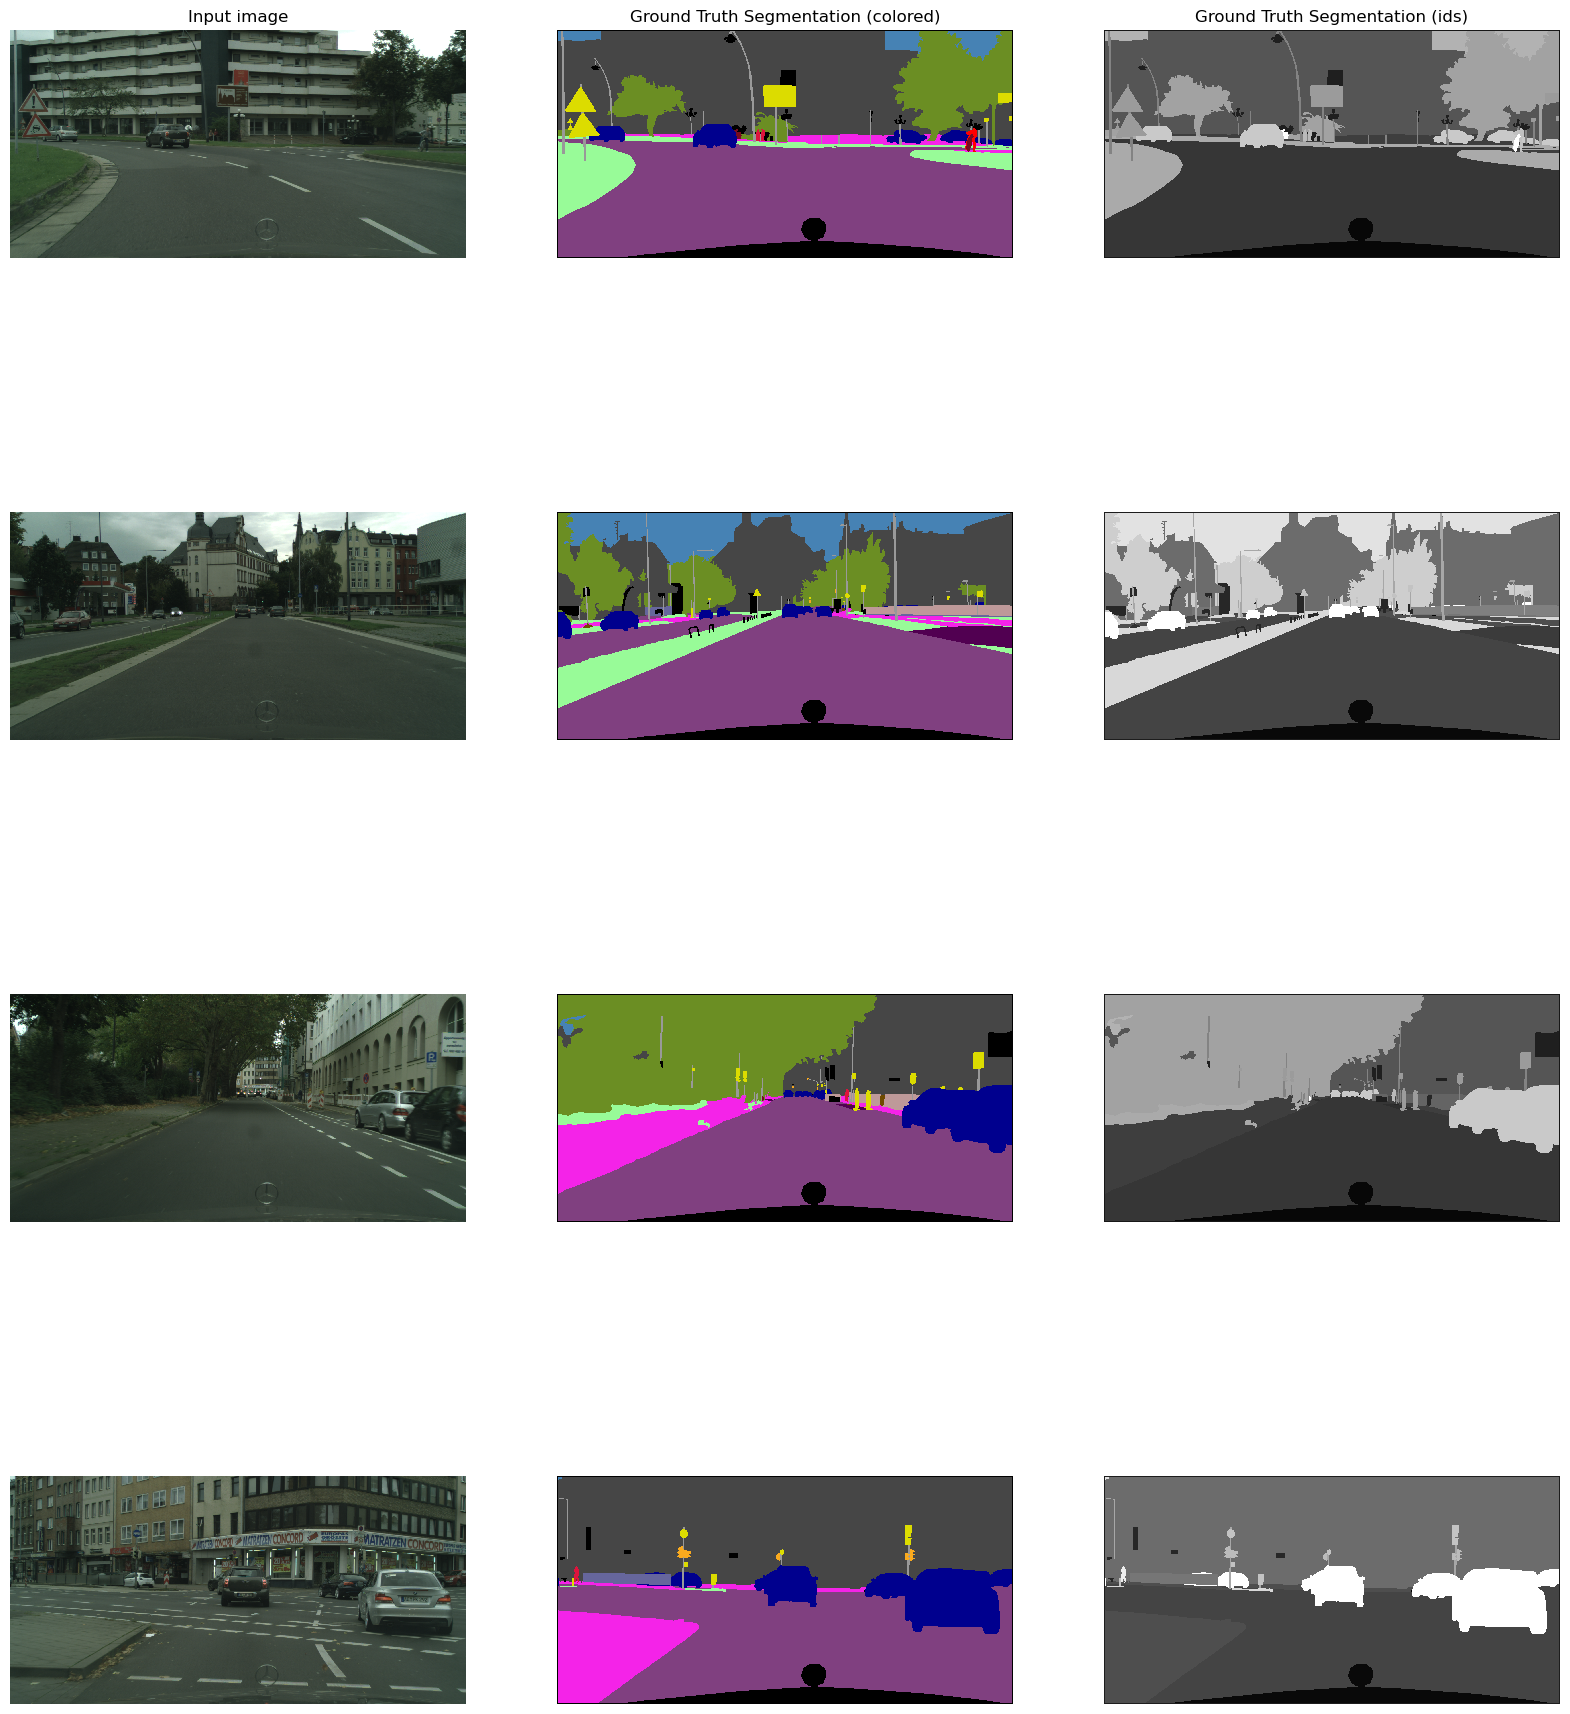

In [10]:
# Show some of the dataset

num_example_imgs = 4
visualize_imgs(train_dataset[0:num_example_imgs])
        

TODO:

- Create model
- Create tensor that uses one hot encoding for ids, not just a flat image
- Use a UNet
- Create trainer (use dataloader, load to device)
- Use a good loss function